# INTRODUCTION
# Submitted by - Ritij Raj
# Roll No- 24/SE/144

## APPROACH
### FasterRCNN + CLIP

- I am using FasterRCNN for its robust object detection capabilities and CLIP (Contrastive Language-Image Pre-training) for its dual-encoder model that takes both images and natural language text as input.
- Instead of using a traditional, fixed-class classifier in the Faster R-CNN's detection head, I integrated the outputs of CLIP. The visual features extracted by CLIP's vision encoder are used by the RPN to propose regions. The text query, encoded by CLIP's text encoder, provides the semantic target for the detection head. This allows the model to search for and localize objects based on a free-form text query, not just a predefined list of classes.

# IMPORTS

In [10]:
import torch
import os
import random
from PIL import Image
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CocoDetection
from torch.utils.data import Dataset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator
import json
import tempfile
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
!pip install git+https://github.com/openai/CLIP.git
import clip 
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qy5isroj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qy5isroj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


# PATHS

In [31]:
train_images = "/kaggle/input/ritijrajaims/train"
train_ann = "/kaggle/input/ritijrajaims/train/_annotations.coco.json"
with open(train_ann) as f:
    annotations = json.load(f)
def collate_fn(batch):
    return tuple(zip(*batch))


categories = annotations["categories"]
class_names = [c["name"] for c in categories]
num_classes = len(class_names) + 1


# Transformers for adding augmentation in the dataset to prevent overfitting

In [32]:
class ToTensorTransform:
    def __call__(self, image, target):
        return F.to_tensor(image), target

class TrainTransform:
    def __init__(self, hflip_prob=0.5, scale_range=(0.5, 2.0)):
        self.hflip_prob = hflip_prob
        self.scale_range = scale_range

    def __call__(self, image, target):
        # Random horizontal flip
        if random.random() < self.hflip_prob:
            image = F.hflip(image)
            if "boxes" in target:
                boxes = target["boxes"]
                boxes[:, [0, 2]] = image.width - boxes[:, [2, 0]]
                target["boxes"] = boxes

        # Random scaling
        scale_factor = random.uniform(*self.scale_range)
        new_w = int(image.width * scale_factor)
        new_h = int(image.height * scale_factor)
        image = F.resize(image, [new_h, new_w])

        if "boxes" in target:
            boxes = target["boxes"] * scale_factor
            target["boxes"] = boxes

        # Convert to tensor
        image = F.to_tensor(image)
        return image, target

# Custom Dataset
## Main Points

- **Efficient Data Handling**: The class pre-processes the annotation file by creating a map from image_id to image information and another map from image_id to its corresponding annotations.
  
- **COCO Annotation Compatibility**: The code is designed to work directly with the standard COCO annotation format.

  
- **Supports Data Transformations**: The transforms parameter enables on-the-fly data augmentation.
  
  

In [33]:
class CustomCocoDataset(Dataset):
    def __init__(self, img_dir, annotations_json, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms

        # Map image_id to image info
        self.imgs = {img['id']: img for img in annotations_json['images']}
        
        # Map image_id to annotations
        from collections import defaultdict
        ann_map = defaultdict(list)
        for ann in annotations_json['annotations']:
            ann_map[ann['image_id']].append(ann)
        self.ann_map = ann_map

        # Keep a list of image_ids
        self.ids = list(self.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img_info = self.imgs[image_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        anns = self.ann_map[image_id]
        boxes = [a['bbox'] for a in anns] 
        boxes = torch.tensor([[x, y, x+w, y+h] for x, y, w, h in boxes], dtype=torch.float32)
        labels = torch.tensor([a['category_id'] for a in anns], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes.float()             
        target['labels'] = labels.long()             
        target['image_id'] = torch.tensor([image_id], dtype=torch.int64)
        target['area'] = (target['boxes'][:, 3] - target['boxes'][:, 1]) * \
                         (target['boxes'][:, 2] - target['boxes'][:, 0])
        target['iscrowd'] = torch.zeros((boxes.shape[0],), dtype=torch.int64)


        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

# Creating the Dataset with Splits for training and validation

In [34]:
full_dataset = CustomCocoDataset(train_images, annotations, transforms=TrainTransform())

val_percent = 0.3
val_size = int(len(full_dataset) * val_percent)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


val_dataset.dataset.transforms = ToTensorTransform()

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


# Building Model with RPN settings for the recognition of small objects in a dense image

In [35]:
def build_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    anchor_generator = AnchorGenerator(
        sizes=((16,), (32,), (64,), (128,), (256,)), 
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator
    )
    # RPN settings
    model.transform.min_size = [600]  
    model.rpn.pre_nms_top_n_train = 10000
    model.rpn.pre_nms_top_n_test = 10000
    model.rpn.post_nms_top_n_train = 5000
    model.rpn.post_nms_top_n_test = 5000
   
    model.rpn.nms_thresh = 0.7
    # ROI threshold
    model.roi_heads.score_thresh = 0.05
    # Transform size
    model.transform.max_size = 1000
    return model

# For extracting annotations for validation set from the original annotations

In [36]:
def get_val_coco_from_subset(full_annotations, val_subset):
    dataset = val_subset.dataset
    val_indices = val_subset.indices

    val_imgs = [dataset.imgs[dataset.ids[i]] for i in val_indices]
    val_img_ids = set(img['id'] for img in val_imgs)
    val_anns = [ann for ann in full_annotations['annotations'] if ann['image_id'] in val_img_ids]

    val_coco_json = {
        "info": {"description": "Temporary validation dataset"},
        "licenses": [],
        "images": val_imgs,
        "annotations": val_anns,
        "categories": full_annotations["categories"]
    }
    return val_coco_json

# Training Model
## Main points

- **Mixed Precision Training**: The code uses torch.cuda.amp.GradScaler() and torch.amp.autocast(enabled=True, device_type='cuda') to enable mixed precision training.
  
- **Regularization**: The line weight_decay=0.0005 in the torch.optim.SGD optimizer adds a penalty to the loss function. This penalty is proportional to the square of the model's weights.

  
- **The code implements a best-model saving strategy**. It tracks a validation metric—in this case, avg_det_per_image—and saves the model's state dictionary to a file (best_model.pth) only when a new, better score is achieved.

  
- The function takes several key **hyperparameters** as arguments, including num_epochs, lr (learning rate), and score_thresh. This makes the training loop highly flexible and easy to tune without needing to modify the function's internal logic. 


In [37]:
def train_model(model, train_loader, val_subset, full_annotations, device,
                num_epochs=30, lr=0.005, score_thresh=0.5, save_path="/kaggle/working/best_model.pth"):
    
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_avg_detections = []
    best_val_det = -float('inf')  # Track best validation metric

    # Prepare temporary COCO JSON for validation
    val_coco_json = get_val_coco_from_subset(full_annotations, val_subset)
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.json') as f:
        json.dump(val_coco_json, f)
        val_json_path = f.name
    coco_gt = COCO(val_json_path)

    for epoch in range(num_epochs):
        
        # Training
        
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            with torch.amp.autocast(enabled=True, device_type='cuda'):
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        torch.cuda.empty_cache()

       
        # Validation: avg detections & prepare predictions
       
        model.eval()
        total_detections = 0
        num_images = 0
        predictions = []

        with torch.no_grad():
            for idx in range(len(val_subset)):
                img, target = val_subset[idx]
                img_tensor = img.to(device).unsqueeze(0)
                output = model(img_tensor)[0]

                # Count detections above threshold
                scores = output['scores']
                keep = scores > score_thresh
                total_detections += keep.sum().item()
                num_images += 1

                boxes = output['boxes'][keep].cpu().numpy()
                labels = output['labels'][keep].cpu().numpy()
                scores = output['scores'][keep].cpu().numpy()
                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = box
                    w, h = x2 - x1, y2 - y1
                    predictions.append({
                        "image_id": int(target["image_id"]),
                        "category_id": int(label),
                        "bbox": [x1, y1, w, h],
                        "score": float(score)
                    })

        avg_det_per_image = total_detections / num_images if num_images > 0 else 0
        val_avg_detections.append(avg_det_per_image)

       
        # Evaluate COCO mAP
        
        if len(predictions) > 0:
            coco_dt = coco_gt.loadRes(predictions)
            coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
        else:
            print("No predictions above threshold for this epoch. Skipping COCO evaluation.")

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, "
              f"Avg detections/image = {avg_det_per_image:.2f}")

       
        # Save best model
       
        if avg_det_per_image > best_val_det:
            best_val_det = avg_det_per_image
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model at epoch {epoch+1} with val detections {best_val_det:.2f}")

# Initializing the model and the training loop 

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(num_classes)

train_model(model, train_loader, val_dataset, annotations, device,
            num_epochs=40, lr=0.005, score_thresh=0.1)

/tmp/ipykernel_107/2296979342.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
No predictions above threshold for this epoch. Skipping COCO evaluation.
Epoch 1: Train Loss = 1.0348, Avg detections/image = 0.00
✅ Saved new best model at epoch 1 with val detections 0.00
No predictions above threshold for this epoch. Skipping COCO evaluation.
Epoch 2: Train Loss = 0.4390, Avg detections/image = 0.00
No predictions above threshold for this epoch. Skipping COCO evaluation.
Epoch 3: Train Loss = 0.4461, Avg detections/image = 0.00
No predictions above threshold for this epoch. Skipping COCO evaluation.
Epoch 4: Train Loss = 0.4332, Avg detections/image = 0.00
No predictions above threshold for this epoch. Skipping COCO evaluation.
Epoch 5: Train Loss = 0.4273, Avg detections/image = 0.00
No predictions above threshold for this epoch. Skipping COCO evaluation.
Epoch 6: Train Loss = 0.4290, Avg detections/image = 0.00
No predictions above threshold for this epoch. Skipping COCO evaluation.

# Initializing CLIP

In [39]:
def init_models(det_model_path, num_classes=295, device="cuda"):
    # Load detection model
    det_model = build_model(num_classes)
    det_model.load_state_dict(torch.load(det_model_path, map_location=device))
    det_model.to(device).eval()

    # Load CLIP
    clip_model, preprocess = clip.load("ViT-B/32", device=device)

    return det_model, clip_model, preprocess

# Detecting objects in the image and creating bounding boxes

In [40]:
def run_detection(det_model, image_path, device="cuda", score_thresh=0.4):
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = det_model(img_tensor)[0]

    boxes, scores = outputs["boxes"], outputs["scores"]
    keep = scores > score_thresh
    return img, boxes[keep], scores[keep]

# Encoding the bounding boxes and the text query and checking there cosine similarity

In [41]:
def rank_by_clip(img, boxes, clip_model, preprocess, text_prompt, device="cuda"):
    text_features = clip_model.encode_text(clip.tokenize([text_prompt]).to(device))

    best_box = None
    best_score = -1

    for box in boxes:
        crop = img.crop(box.tolist())
        crop_tensor = preprocess(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = clip_model.encode_image(crop_tensor)
            score = torch.cosine_similarity(image_features, text_features).item()

        if score > best_score:
            best_score = score
            best_box = box

    return best_box, best_score

# visualizing the images with the bounding boxs matching the most in the cosine similarity test

In [42]:
def visualize_best_detection(image_path, det_model, clip_model, preprocess, text_prompt, device="cuda", score_thresh=0.4):
    # Run detection
    img, boxes, scores = run_detection(det_model, image_path, device=device, score_thresh=score_thresh)
    
    # Rank boxes using CLIP to select the best one
    best_box, best_score = rank_by_clip(img, boxes, clip_model, preprocess, text_prompt, device=device)
    
    # Plot image
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    ax = plt.gca()
    
    # Draw only the CLIP-selected best box in red
    if best_box is not None:
        x1, y1, x2, y2 = best_box.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y2+15, f'CLIP Score: {best_score:.2f}', color='red', fontsize=12, weight='bold')
    else:
        print("No box detected above the score threshold.")
    
    plt.axis('off')
    plt.show()
    print("Visualization complete.")

# Initializing models for usage

In [43]:

device = "cuda" if torch.cuda.is_available() else "cpu"
det_model, clip_model, preprocess = init_models("/kaggle/working/best_model.pth", num_classes=295, device=device)

# Usage ( Visualizing from another dataset (flickr30k))

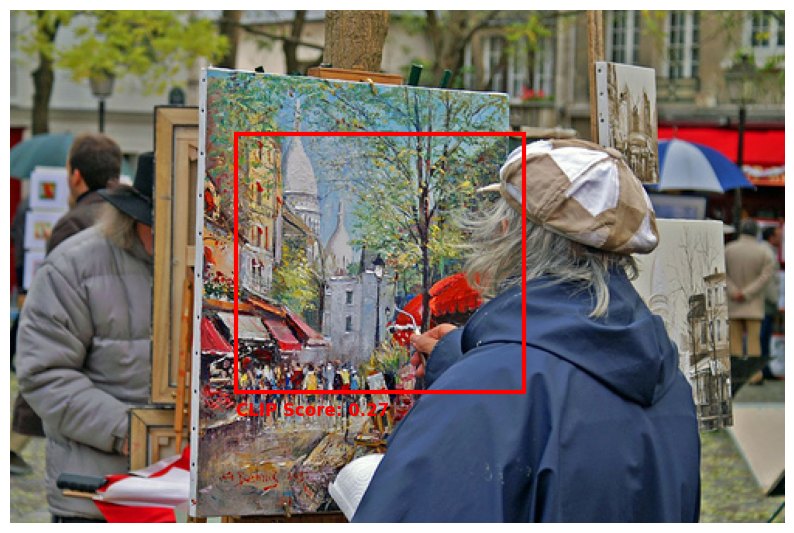

Visualization complete.


In [45]:
image_path1 = "/kaggle/input/flickr30k/Images/100716317.jpg"
text_prompt1 = "lady painting"
visualize_best_detection(image_path1, det_model, clip_model, preprocess, text_prompt1, device=device)

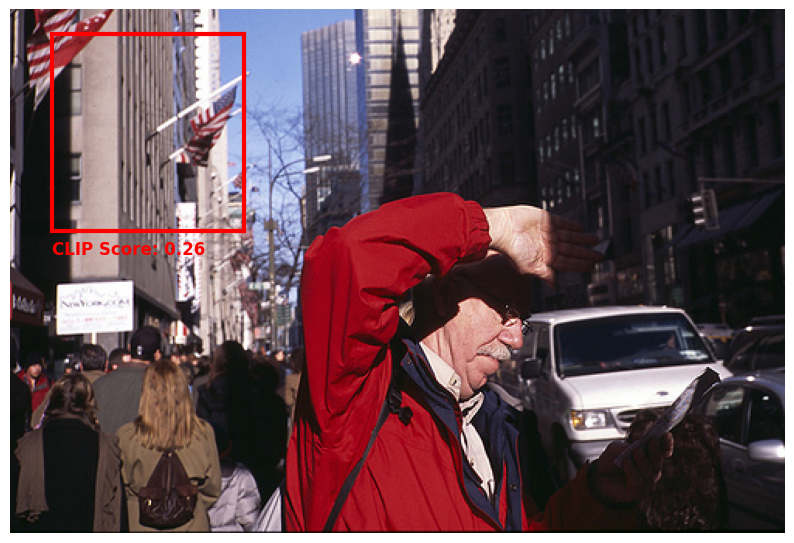

Visualization complete.


In [54]:
image_path2 = "/kaggle/input/flickr30k/Images/101471792.jpg"
text_prompt2 = "american flag"
visualize_best_detection(image_path2, det_model, clip_model, preprocess, text_prompt2, device=device)

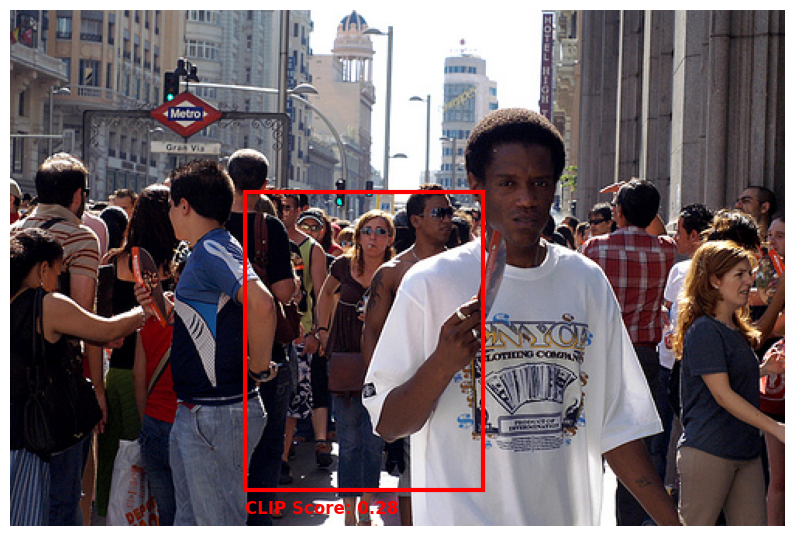

Visualization complete.


In [48]:
image_path3 = "/kaggle/input/flickr30k/Images/1005216151.jpg"
text_prompt3 = "black man in a white t-shirt"
visualize_best_detection(image_path3, det_model, clip_model, preprocess, text_prompt3, device=device)